In [1]:
import pandas as pd
import json
import numpy as np
from bokeh.plotting import figure, show, output_notebook
from scipy.stats import gaussian_kde
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sbn
from scipy import stats

In [2]:
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
%matplotlib inline

In [4]:
# Load strain genotypes
with open("../Data/Mutation_data/Strain_to_genes.json") as infile:
    genotypes = json.load(infile)
genotypes["MG1655"] = set()

In [5]:
# Load cross tolerance and M9 growth rates
growth_data = pd.read_csv("../Data/Growth_data/Cross_tolerance/Cleaned_growth_rates.tsv", sep="\t", index_col=0)
growth_data = growth_data[growth_data["strain"].isin(genotypes)]  # Filter hypermutators out

m9_data = pd.read_csv("../Data/Growth_data/M9/M9_normalised_growth.csv")
m9_data = m9_data[m9_data["strain"].isin(genotypes)]  # Filter hypermutators out

In [6]:
df = pd.concat([growth_data, m9_data])
del df["exp_name"]
del df["tOD1"]

compounds = {"adipate": "ADIP",
            "hexanoate": "HEXA",
            "glutarate": "GLUT",
            "HMDA": "HMDA",
            "1,2-propanediol": "12PD",
            "2,3-butanediol": "23BD",
            "octanoate": "OCTA",
            "butanol": "BUT",
            "putrescine": "PUTR",
            "isobutyrate": "IBUA",
            "coumarate": "COUM"}

reverse_compounds = {value[0:3]: key for key, value in compounds.items()}

def strain_to_compound(strain):
    if strain == "MG1655":
        return None
    else:
        return reverse_compounds[strain[:3]]
    
df["evolved_compound"] = df["strain"].map(strain_to_compound)

In [7]:
short_df = df.groupby(["strain", "grown_compound"]).mean().reset_index().pivot("strain", "grown_compound", "growth_rate")
rel_short_df = df.groupby(["strain", "grown_compound"]).mean().reset_index().pivot("strain", "grown_compound", "rel_growth_rate")
min_rate, max_rate = np.nanmin(short_df.values), np.nanmax(short_df.values)
short_df["evolved_compound"] = short_df.index.map(strain_to_compound)
rel_short_df["evolved_compound"] = rel_short_df.index.map(strain_to_compound)

In [25]:
short_df

grown_compound,"1,2-propanediol","2,3-butanediol",HMDA,M9,NaCl,adipate,butanol,coumarate,glutarate,hexanoate,isobutyrate,octanoate,putrescine,evolved_compound
strain,,,,,,,,,,,,,,
12PD4-6,0.649652,0.441688,0.000000,0.769154,0.000000,0.180535,0.000000,0.139483,0.182738,0.602023,0.000000,0.344891,0.000000,"1,2-propanediol"
12PD6-3,0.574152,0.381388,0.072504,0.730751,0.039462,0.221241,0.000000,0.502618,0.150099,0.531056,0.000000,0.063704,0.000000,"1,2-propanediol"
12PD6-9,0.573040,0.392165,0.224429,0.684707,0.106110,0.197308,0.100214,0.490927,0.150431,0.507087,0.000000,0.166536,0.000000,"1,2-propanediol"
23BD1-6,0.522255,0.355380,0.167164,0.575060,0.152886,0.229587,0.464972,0.000000,0.187731,0.437042,0.087500,0.388003,0.238517,"2,3-butanediol"
23BD1-9,0.506389,0.320371,0.057716,0.585185,0.148932,0.214155,0.465388,0.000000,0.175441,0.425412,0.089511,0.408148,0.218838,"2,3-butanediol"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PUTR7-7,0.312405,0.146421,0.414121,0.789593,0.276499,0.173457,0.000000,0.267912,0.296133,0.358561,0.367809,0.459541,0.363027,putrescine
PUTR7-9,0.322382,0.152201,0.439250,0.768044,0.278959,0.178299,0.000000,0.265197,0.304723,0.339103,0.348315,0.424475,0.333681,putrescine
PUTR8-10,0.241574,0.064264,0.329841,0.719586,0.103025,0.192500,0.133942,0.535282,0.251614,0.405794,0.164005,0.345994,0.454514,putrescine


## Make cross-tolerance heat map

In [8]:
def prettify(string):
    if string == string.lower():
        return string.capitalize()
    else:
        return string

def lprettify(l):
    return [prettify(_) for _ in l]


def two_color_func(val):
    """
    Red is higher, blue is lower. 0 is white.
    """
    a = 240
    assert -1 <= val <= 1, val
    if val <= 0:
        val = -val
        #val = val**1.2
        red = a + (255-a)*val
        green = a - (a*0.9)*val #+ (150-a)*val
        blue = a - (a*0.9)*val #+ (150-a)*val
    else:
        #val = val**1.2
        red = a - (a*0.8)*val
        green = a - (a*0.8)*val
        blue = a + (255-a)*val
    col = "#%2.2x%2.2x%2.2x" % (int(blue), int(green), int(red))
    return col


def cat_dot_plot(df, color_df=None, fig=None, legend_min="", legend_max=""):
    plot_df = df.copy()
    min_size = 0.08
    max_size = 1
    plot_df = plot_df - plot_df.values.min() + 0.08
    plot_df = plot_df / plot_df.values.max() * 0.75
    if color_df is None:
        color_df = plot_df
    else:
        color_df = color_df.copy()
    x_cats = list(df)
    y_cats = list(df.index)
    
    if fig is None:
        fig = figure(x_range=lprettify(x_cats)+[""]*2, y_range=lprettify(y_cats), width=int(1000*1.3), height=int(850*1.3))
    
    fig.quad(left=0.5, right=2.5, bottom=9.5, top=11.48, color="#e2e2e2")
    fig.quad(left=2.5, right=4.5, bottom=7.5, top=9.5, color="#e2e2e2")
    fig.quad(left=4.5, right=6.5, bottom=5.5, top=7.5, color="#e2e2e2")
    fig.quad(left=6.5, right=8.5, bottom=3.5, top=5.5, color="#e2e2e2")
    fig.line([0, 11.4], [12, 0.6], color="darkblue", line_alpha=0.4)
    
    xs = []
    ys = []
    sizes = []
    colors = []
    for i, y in enumerate(y_cats):
        for j, x in enumerate(x_cats):
            xs.append(j + 1)
            ys.append(i + 1)
            circle_size = np.sqrt(plot_df.iloc[i, j]) / 2 * 1.2
            sizes.append(circle_size)
            colors.append(two_color_func(color_df.iloc[i, j]))
    fig.circle(xs, ys, radius=sizes, color=colors, line_color="#666666", line_width=0.5)
    #fig.text(xs, ys, sizes)
    
    # Add color legend
    leg_pos = (15, 7)
    reso = 50
    mini = color_df.values.min()
    maxi = color_df.values.max()
    color_ran = np.linspace(mini, maxi, reso)
    leg_height = 3
    for i in range(reso):
        fig.rect(
            x=leg_pos[0]-0.5,
            y=leg_pos[1]+leg_height/float(reso)*i,
            height=leg_height/float(reso),
            width=1,
            color=two_color_func(color_ran[i])
        )
    fig.text(
        x=[leg_pos[0]-1.4, leg_pos[0]-1.3],
        y=[leg_pos[1]-0.5, leg_pos[1]-0.3+leg_height+0.5],
        text=[str(round(legend_min, 2)) + " /h", str(round(legend_max, 2)) + " /h"],
        text_font_size="30px"
    )

    fig.line([len(x_cats)+0.55, len(x_cats)+0.55], [0, len(y_cats)+1], color="black", line_width=0.1)
    
    fig.xaxis.major_label_orientation = 1
    fig.grid.grid_line_color = None

    return fig

In [9]:
column_order = [
    "1,2-propanediol", "2,3-butanediol", "glutarate", "adipate",  "putrescine", "HMDA",  
     "isobutyrate", "coumarate", "butanol", "octanoate", "hexanoate",
    "NaCl"]

index_order = [
    "1,2-propanediol", "2,3-butanediol", "glutarate", "adipate",  "putrescine", "HMDA",
     "isobutyrate", "coumarate", "butanol",  "octanoate", "hexanoate",
    "None (MG1655)"] 

In [10]:
heatmap_df = short_df.copy()
heatmap_df.loc["MG1655", "evolved_compound"] = "None (MG1655)"
heatmap_df = heatmap_df.groupby("evolved_compound").mean()
heatmap_df = heatmap_df.reindex(index_order[::-1])[column_order]
heatmap_df["M9"] = df[df["grown_compound"] == "M9"].fillna("None (MG1655)").groupby("evolved_compound").mean()["growth_rate"]
#heatmap_df = np.log(heatmap_df)

std_df = short_df.copy()
std_df.loc["MG1655", "evolved_compound"] = "None (MG1655)"
std_df = std_df.groupby("evolved_compound").std()
std_df = std_df.reindex(index_order[::-1])[column_order]
std_df["M9"] = df[df["grown_compound"] == "M9"].fillna("None (MG1655)").groupby("evolved_compound").std()["growth_rate"]

def percentile_func(ser, q):
    # print(ser.columns)
    #ser = ser[pd.notnull(ser)]
    return pd.Series({c: np.nanpercentile(ser[c], q) for c in ser if c != "evolved_compound"})

q3_df = short_df.copy()
q3_df.loc["MG1655", "evolved_compound"] = "None (MG1655)"
q3_df = q3_df.groupby(["evolved_compound"]).apply(percentile_func, 75)
q3_df = q3_df.reindex(index_order[::-1])[column_order]
q3_df["M9"] = df[df["grown_compound"] == "M9"].fillna("None (MG1655)")[["evolved_compound", "growth_rate"]].groupby(
    "evolved_compound"
).apply(percentile_func, 75)["growth_rate"]

q1_df = short_df.copy()
q1_df.loc["MG1655", "evolved_compound"] = "None (MG1655)"
q1_df = q1_df.groupby(["evolved_compound"]).apply(percentile_func, 25)
q1_df = q1_df.reindex(index_order[::-1])[column_order]
q1_df["M9"] = df[df["grown_compound"] == "M9"].fillna("None (MG1655)")[["evolved_compound", "growth_rate"]].groupby(
    "evolved_compound"
).apply(percentile_func, 25)["growth_rate"]

In [11]:
normalisation_means = heatmap_df.loc["None (MG1655)", :]
color_df = (heatmap_df - normalisation_means)
print(color_df.values.min(), color_df.values.max())
legend_min, legend_max = color_df.values.min(), color_df.values.max()

color_df /= max(abs(color_df.values.max()), abs(color_df.values.min()))

heatmap_df = heatmap_df[1:]
std_df = std_df[1:]
color_df = color_df[1:]
q1_df = q1_df[1:]
q3_df = q3_df[1:]

-0.35088790808715964 0.4174542091274795


In [12]:
comp_to_shorthand = {k: v for k, v in compounds.items()}
comp_to_shorthand["M9"] = "M9"
comp_to_shorthand["NaCl"] = "NaCl"

In [13]:
comp_to_shorthand2 = comp_to_shorthand.copy()

for i in comp_to_shorthand2.keys():
    new_name = comp_to_shorthand.get(i)+' ('+str(short_df[short_df['evolved_compound']==i].index.size)+')'
    comp_to_shorthand2.update([(i,new_name)])

In [14]:
heatmap_df

grown_compound,"1,2-propanediol","2,3-butanediol",glutarate,adipate,putrescine,HMDA,isobutyrate,coumarate,butanol,octanoate,hexanoate,NaCl,M9
evolved_compound,,,,,,,,,,,,,
hexanoate,0.359365,0.106794,0.080190,0.053713,0.065889,0.092795,0.212131,0.582484,0.029721,0.268210,0.538753,0.147674,0.731598
octanoate,0.288452,0.072094,0.177962,0.106489,0.071560,0.111121,0.181018,0.476888,0.027070,0.390874,0.354891,0.098938,0.824620
butanol,0.420710,0.263053,0.295745,0.281960,0.350547,0.283374,0.411640,0.473056,0.413320,0.396158,0.327301,0.260476,0.752469
coumarate,0.365965,0.138839,0.200686,0.157145,0.000000,0.069717,0.078220,0.703918,0.022098,0.364434,0.381224,0.017040,0.680775
isobutyrate,0.374684,0.120541,0.198125,0.174116,0.170093,0.227457,0.575636,0.489029,0.096059,0.327510,0.528364,0.082799,0.942549
HMDA,0.413785,0.164136,0.377606,0.356768,0.408710,0.548994,0.352394,0.472823,0.049819,0.511859,0.510978,0.334395,0.786672
putrescine,0.381272,0.209383,0.313998,0.261864,0.384495,0.393345,0.329465,0.445319,0.067947,0.317567,0.434397,0.258598,0.773874
adipate,0.406870,0.228872,0.409201,0.362411,0.155186,0.135222,0.220007,0.361850,0.039082,0.174360,0.460043,0.134652,0.711558
glutarate,0.364759,0.117175,0.446512,0.403452,0.182260,0.138017,0.237977,0.359572,0.032329,0.392731,0.459882,0.146719,0.548020


8.8
10.4


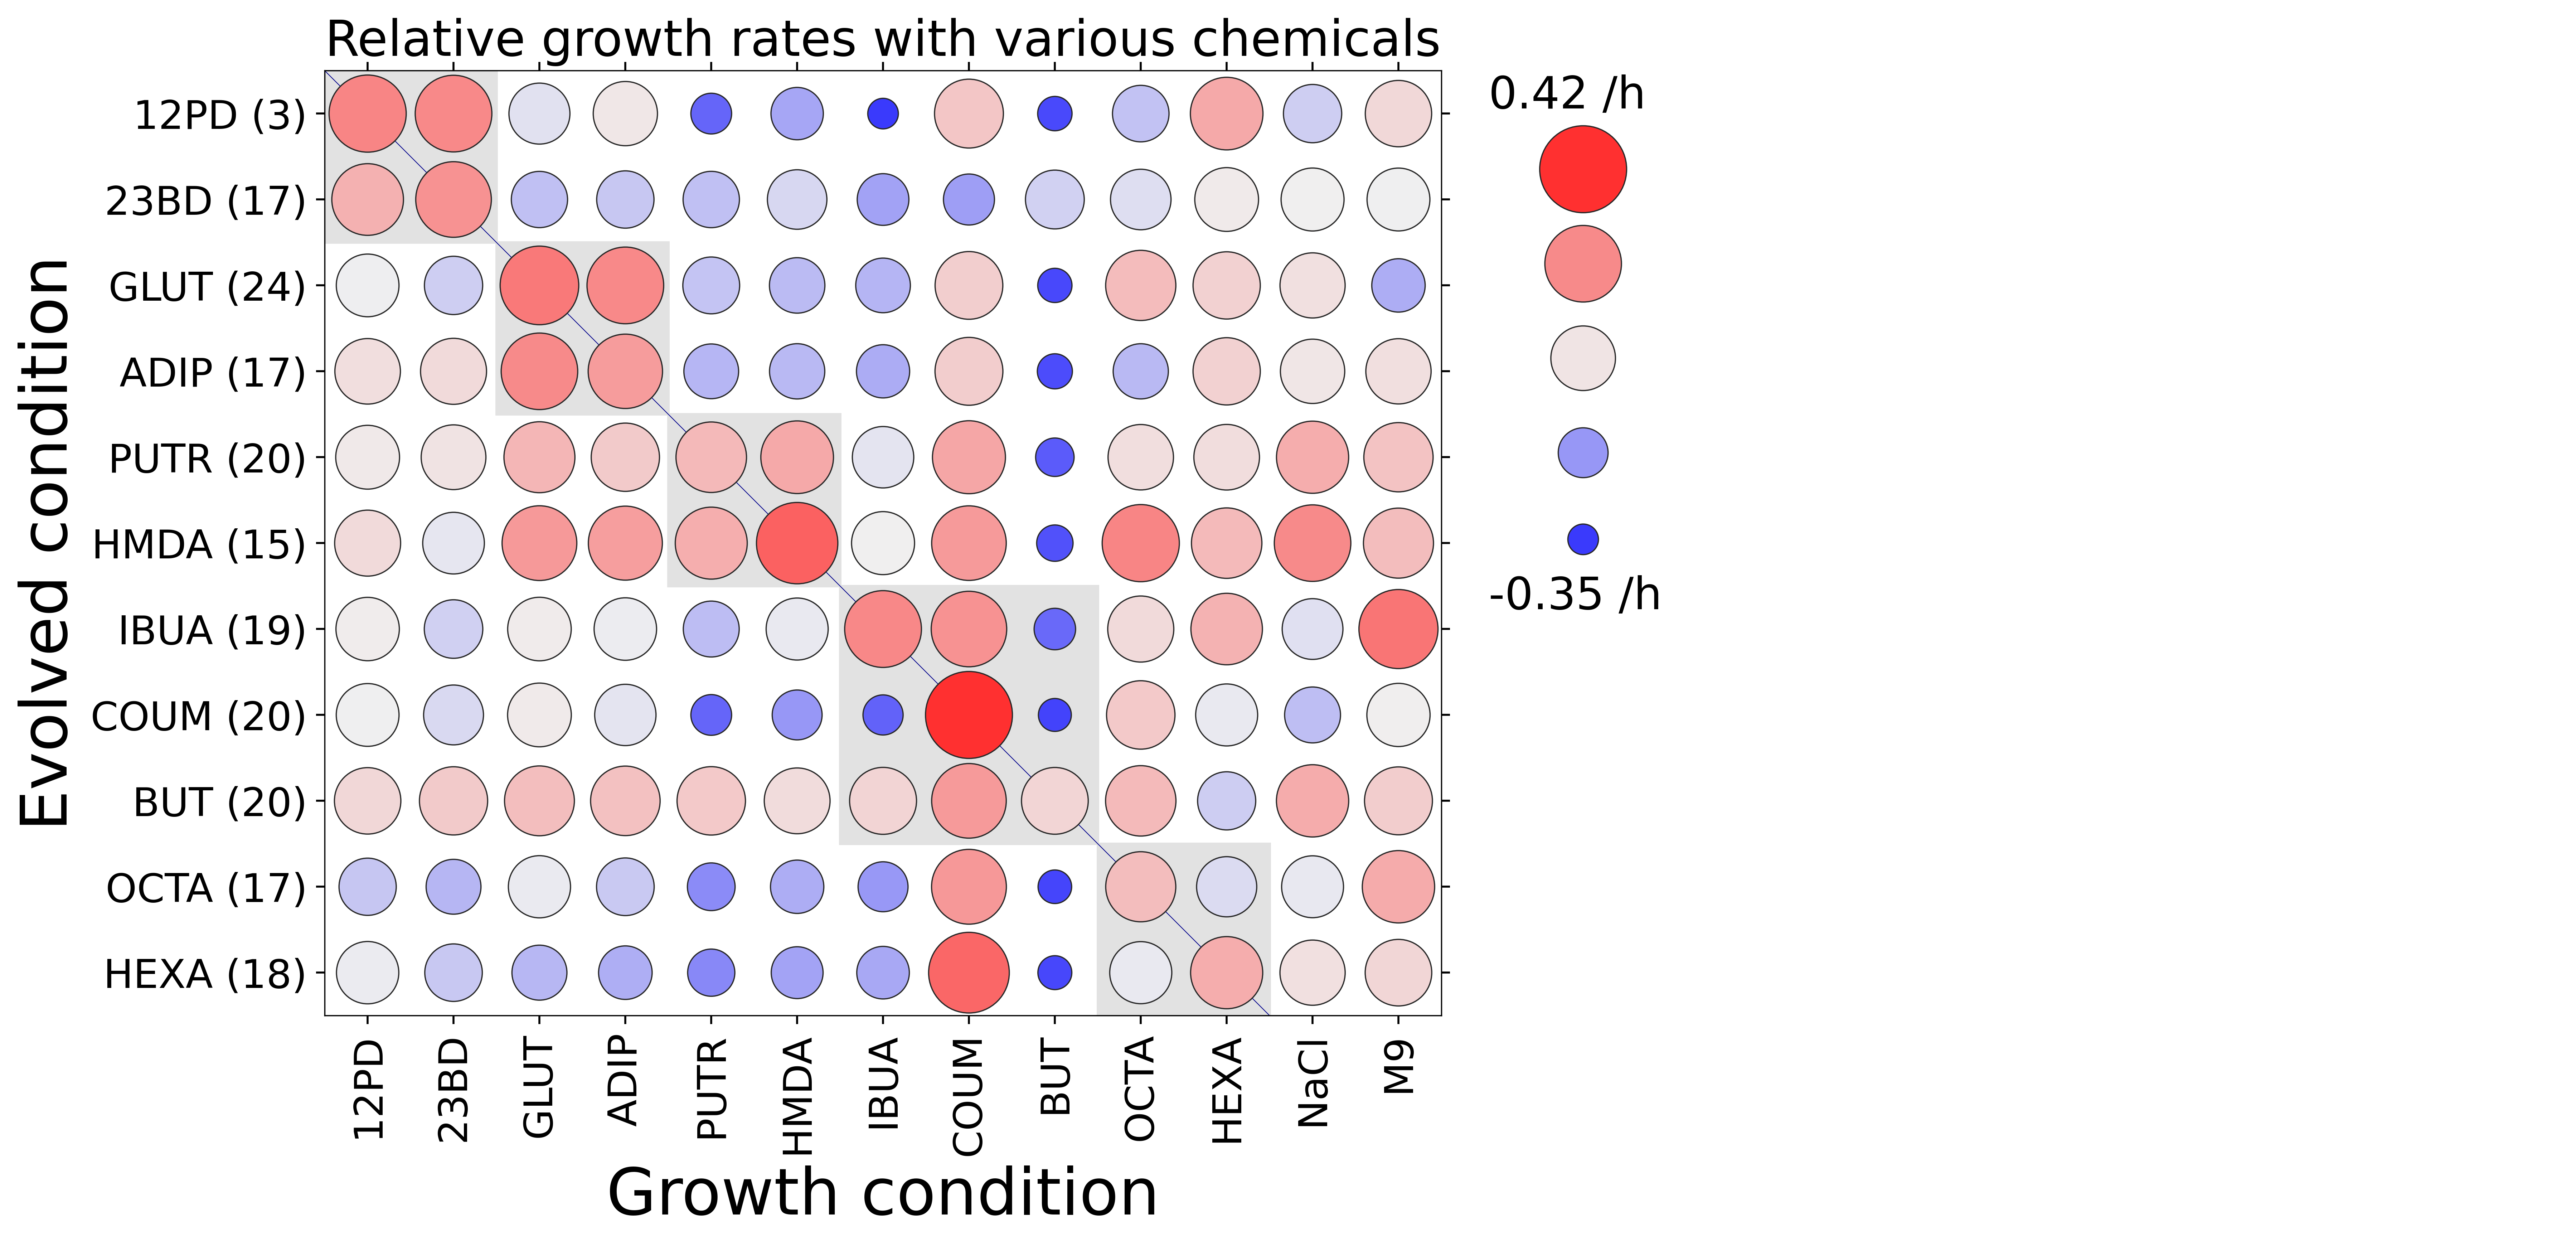

In [15]:
mpl.rcParams['pdf.fonttype'] = 42

num_cols = 13
num_rows = 11

size = 4
scale = 0.2

# The size of the figure in inches
height = size * scale * num_rows
width = size * scale * num_cols
print(height)
print(width)

# Make the figure
fig = plt.figure(figsize=[width, height], dpi=500)

# We need some space in the margins for labels. To keep space for the legend and keep the aspect ratio
# we add margins to all 4 sides
margin = 0.2
ax1 = fig.add_axes([margin, margin, 1-2*margin, 1-2*margin])
ax2 = fig.add_axes([1-margin, margin, 1-2*margin, 1-2*margin])

# Hide the axes for the legend part of the plot
ax2.axis("off")

# Normalize the data df
plot_df = heatmap_df - normalisation_means
upper_df = q3_df - normalisation_means #plot_df + std_df
lower_df = q1_df - normalisation_means #plot_df - std_df
min_size = 0.08
max_size = 1

max_value = upper_df.values.max()
min_value = lower_df.values.min()

min_size = 0.1
max_size = 0.9

scaling_slope = (max_size - min_size) / (max_value - min_value)
scaling_intercept = max_size - scaling_slope * max_value

plot_df =  plot_df  * scaling_slope + scaling_intercept
lower_df = lower_df * scaling_slope + scaling_intercept
upper_df = upper_df * scaling_slope + scaling_intercept


x_cats = list(plot_df)
y_cats = list(plot_df.index)

# Make white background
ax1.add_artist(plt.Rectangle((-0.5, -0.5), num_cols, num_rows, color="white", zorder=-1))

# Make the gray compound category rectangles
for i in [0, 2, 4]:
    rect = plt.Rectangle((i-0.5, 8.5-i), 2, 2, color="#e2e2e2", zorder=0)
    ax1.add_artist(rect)
    
for i in [7]:
    rect = plt.Rectangle((i-1.5, 8.5-i), 3, 3, color="#e2e2e2", zorder=0)
    ax1.add_artist(rect)
    
for i in [9]:
    rect = plt.Rectangle((i-0.5, 8.5-i), 2, 2, color="#e2e2e2", zorder=0)
    ax1.add_artist(rect)

# Make the diagonal line
ax1.plot([-0.5, 10.5], np.array([10.5, -0.5]), zorder=1, color="darkblue", linewidth=0.3)

# Draw all the circles
for y, y_cat in enumerate(y_cats):
    for x, x_cat in enumerate(x_cats):
        circle_size = np.sqrt(plot_df.iloc[y, x]) / 2 * 1.1
        color = two_color_func(color_df.iloc[y, x])
        
        circle = plt.Circle((x, y), circle_size, facecolor=color, edgecolor="#282828", linewidth=0.5)
        ax1.add_artist(circle)


# Set the axis ranges
ax1.set_ylim([-0.5, num_rows-0.5])
ax1.set_xlim([-0.5, num_cols-0.5])

ax2.set_xlim([0, 13/11.])


# Set the ticks + labels
ax1.set_xticks(range(num_cols))
ax1.set_yticks(range(num_rows))
ax1.tick_params(top="off", right="off", direction="out")

tick_size = 16
ax1.set_xticklabels(map(comp_to_shorthand.get, x_cats), fontsize=tick_size, rotation=90)
ax1.set_yticklabels(map(comp_to_shorthand2.get, y_cats), fontsize=tick_size)

# Set the axis labels
labelsize = 26
ax1.set_xlabel("Growth condition", fontsize=labelsize)
ax1.set_ylabel("Evolved condition", fontsize=labelsize)

# Make the "frame" of axes 1 thinner
[(i.set_linewidth(0.5), i.set_color("black")) for i in ax1.spines.values()]

# Add color legend
leg_pos = (0.05, 0.5)
reso = 48
mini = color_df.values.min()
maxi = color_df.values.max()
color_ran = np.linspace(mini, maxi, reso)
mini = plot_df.values.min()
maxi = plot_df.values.max()
size_ran = np.linspace(mini, maxi, reso)
leg_height = 0.4
leg_width = 0.10
for i in range(reso):
    pos_i = leg_pos + np.array([0, i*leg_height/float(reso)])
    #rect = plt.Rectangle(pos_i, leg_width, leg_height/reso, color=two_color_func(color_ran[i]))
    if i == 0 or (i+1) % int(reso // 4) == 0: # Add a size legend
        siz = np.sqrt(size_ran[i]) / 2 * 1. / 10
        color = two_color_func(color_ran[i])
        circ = plt.Circle(
            (pos_i[0]+0.1, pos_i[1]+0.004), siz, facecolor=color, edgecolor="#282828", linewidth=0.5
        )
        ax2.add_artist(circ)
    #ax2.add_artist(rect)

poly = plt.Polygon(np.array([(2, 2), (3, 3), (5, 3), (5, 2)]))

legend_fontsize = 18
ax2.text(leg_pos[0], leg_pos[1]-0.07, str(round(legend_min, 2)) + " /h", fontsize=legend_fontsize)
ax2.text(leg_pos[0], leg_pos[1]+leg_height+0.06, str(round(legend_max, 2)) + " /h", fontsize=legend_fontsize)

ax1.set_title("Relative growth rates with various chemicals", fontsize=20)


#plt.show()

plt.savefig("../Plots/Figure 5a_cross_tolerance.svg")

## Make sameclass compounds plots

23BD value    0.134027
dtype: float64
GLUT value    0.060542
dtype: float64
ADIP value    0.088497
dtype: float64
PUTR value    0.142402
dtype: float64
HMDA value    0.195051
dtype: float64
IBUA value    0.04802
dtype: float64


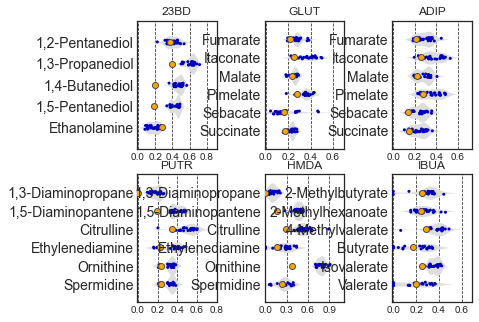

In [17]:
plt.style.use("seaborn-white")

fig = plt.figure(figsize=[6, 8])

compounds = {
   "23BD": "2,3-butanediol",
    "GLUT": "glutarate",
    "ADIP": "adipate",
    "PUTR": "putrescine",
    "HMDA": "HMDA",
    "IBUA": "isobutyrate",
}

xmin = -0.01
dif = 0.2

for i, c in enumerate(compounds.keys()):
    plt.subplot(3, 3, i+1)
    
    plot_df = pd.read_csv("../Data/Growth_data/Sameclass-compounds/" + c + ".csv", index_col=0)
    plot_df.index.name = "strain"
    
    mg_df = plot_df[plot_df.index == "MG1655"]
    plot_df = plot_df[plot_df.index != "MG1655"]
    plot_df = pd.melt(plot_df.reset_index(), id_vars="strain")
    sbn.violinplot(
        y="variable", x="value", data=plot_df, orient="h", inner=None, color="#dddddd",
        linewidth=0, width=1.1
    )
    
    sbn.stripplot(
        y="variable", x="value", data=plot_df, orient="h", color="#0000bb",
        linewidth=0, size=3
    )
    
    sbn.swarmplot(
        y="variable", x="value", data=pd.melt(mg_df.reset_index(), id_vars="strain"),
        color="orange", linewidth=1, size=6
    )
    plt.xlabel("")
    plt.ylabel("")
    plt.grid(axis="x", linestyle="--", color="#333333")
    plt.ylim([len(set(plot_df["variable"])), -1])
    
    if c == "HMDA":
        plt.xticks([0, 0.3, 0.6, 0.9])
    else:
        plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])


    
    plt.xlim([xmin, plot_df.value.max()+dif])
   # print(c, plot_df.groupby("variable").mean()['value'] - mg_df.T['MG1655'].mean())     
    
    print(c, pd.DataFrame(plot_df.groupby("variable").mean()['value'] - mg_df.T['MG1655'].mean()).mean(axis=0))
    
    plt.title(c)
    plt.yticks(fontsize=14)
    
    
plt.subplots_adjust(wspace=0.6)

plt.savefig("../Plots/Figure 5b_tolerance_to_others.svg")

## Make global tolerance plots

In [18]:
comp_name_order = [
    "1,2-propanediol", "2,3-butanediol", "HMDA", "putrescine", "glutarate",
    "adipate", "hexanoate", "octanoate", "coumarate", "isobutyrate", "butanol", "NaCl"
]

comp_order = ["12PD", "23BD","GLUT", "ADIP","PUTR", "HMDA",  "IBUA","COUM", "BUT" , "OCTA","HEXA"]

growth_df = pd.read_csv("../Data/Growth_data/Cross_tolerance/Cleaned_growth_rates.tsv", sep="\t")
long_growth_df = growth_df.copy()
growth_df = growth_df.groupby(["strain", "grown_compound"]).mean().reset_index().pivot("strain", "grown_compound", "rel_growth_rate")[comp_name_order]
raw_growth_df = long_growth_df.groupby(["strain", "grown_compound"]).mean().reset_index().pivot("strain", "grown_compound", "growth_rate")


m9_growth = pd.read_csv("../Data/Growth_data/M9/M9_normalised_growth.csv")
m9_growth = m9_growth[m9_growth["growth_rate"] != 0].groupby("strain").mean()

growth_df["M9"] = m9_growth["rel_growth_rate"]

In [19]:
def tol_metric(row):
        
    if pd.isnull(row["coumarate"]):
        coum = row[comp_name_order].mean()
    else:
        coum = row["coumarate"]
        
    if pd.isnull(row["isobutyrate"]):
        ibua = row[comp_name_order].mean()
    else:
        ibua = row["isobutyrate"]
    if "butanol" in row:
        if pd.isnull(row["butanol"]):
            but = row[comp_name_order].mean()
        else:
            but = row["butanol"]
    return (
        (
            row[["HMDA", "putrescine"]].mean() + 
            row[["glutarate", "adipate"]].mean() + 
            row[["hexanoate", "octanoate"]].mean()
        )
        + ibua + row["2,3-butanediol"] + coum + but
    )

In [20]:
plot_df = growth_df.copy()
plot_df["global"] = plot_df.apply(tol_metric, axis=1) / 7
plot_df["comp"] = plot_df.index.map(lambda x: x.split("-")[0][:-1])
plot_df = plot_df[plot_df["comp"] != "MG165"]
plot_df = plot_df.reindex(sorted(plot_df.index, key=lambda x: comp_order.index(plot_df["comp"][x])))

In [21]:
col_col = {
    '12PD':'Diols',
    '23BD':'Diols',
    'HMDA':'Diamines',
    'PUTR':'Diamines',
    'GLUT':'Diacids',
    'ADIP':'Diacids',
    'HEXA':'Fatty',
    'OCTA':'Fatty',
    'COUM':'Others',
    'IBUA':'Others',
    'BUT':'Others'
}

In [22]:
plot_df['group']=plot_df['comp']
plot_df['group']=plot_df['group'].map(col_col)

In [23]:
len(plot_df['comp'].map(col_col).unique())

5

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


(0.12362447856297931, 0.03905684041762359)
(0.6368044162410001, 3.9090550396067536e-33)


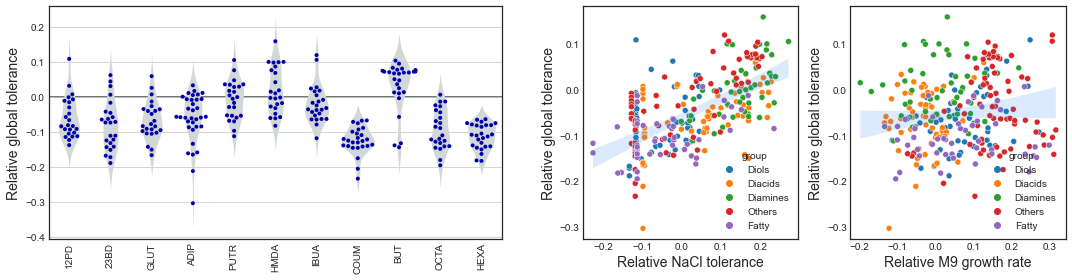

In [24]:
plt.style.use("seaborn-white")
plt.figure(figsize=[15, 4])

fs = 14
line_width=.5

plt.subplot(1, 2, 1)

plt.plot([-0.5, 10.5], [0, 0], zorder=-10, color="#727877", linewidth=2)
sbn.violinplot(x="comp", y="global", data=plot_df, inner=None, 
               color="#d2d8d7", 
               zorder=10, saturation=1, linewidth=0)
sbn.swarmplot(
    x="comp", y="global", data=plot_df,
    color="#0000aa",
    size=4, zorder=15
)
plt.xlabel("")
plt.grid(axis="y")
plt.xticks(rotation=90)
plt.ylabel("Relative global tolerance", fontsize=fs)


plt.subplot(1, 4, 4)
ax = sbn.scatterplot(data=plot_df, x="M9", y="global", hue="group")
sbn.regplot(x="M9", y="global", data=plot_df, ci=99, n_boot=10000, scatter=False, ax=ax,
            line_kws={"alpha": 0, "color": "#0f7bf3"}, 
            #scatter_kws={"s": 10, "color": "black"}
          )
#plt.axhline(0, c="grey", ls="--", lw=line_width)
#plt.axvline(0, c="grey", ls="--", lw=line_width)

plt.xlabel("Relative M9 growth rate", fontsize=fs)
plt.ylabel("Relative global tolerance", fontsize=fs)


pearson_df = plot_df[["M9", "global"]].dropna()
print(stats.pearsonr(pearson_df["M9"], pearson_df["global"]))

plt.subplot(1, 4, 3)
ax = sbn.scatterplot(data=plot_df, x="NaCl", y="global", hue="group")
sbn.regplot(x="NaCl", y="global", data=plot_df, ci=99, scatter=False,
            n_boot=10000, line_kws={"alpha": 0.0, "color": "#0f7bf3"}, 
            ax=ax
          )
#plt.axhline(0, c="grey", ls="--", lw=line_width)
#plt.axvline(0, c="grey", ls="--", lw=line_width)
plt.xlabel("Relative NaCl tolerance", fontsize=fs)
plt.ylabel("Relative global tolerance", fontsize=fs)

pearson_df = plot_df[["NaCl", "global"]].dropna()
print(stats.pearsonr(pearson_df["NaCl"], pearson_df["global"]))

plt.tight_layout()

plt.savefig("../Plots/Figure 5ce - Global tolerance correlations.svg", transparent=True)

In [29]:
plot_df

grown_compound,"1,2-propanediol","2,3-butanediol",HMDA,putrescine,glutarate,adipate,hexanoate,octanoate,coumarate,isobutyrate,butanol,NaCl,M9,global,comp,group
strain,,,,,,,,,,,,,,,,
12PD1-10,0.351151,0.346805,-0.225612,-0.278704,0.072742,0.053331,0.137964,-0.255672,NaN,0.070423,-0.470725,-0.116994,0.186647,-0.047162,12PD,Diols
12PD1-2,0.423014,0.392368,-0.225612,-0.278704,0.036386,0.082049,0.215836,-0.039191,NaN,0.081754,0.315779,-0.116994,0.249728,0.109413,12PD,Diols
12PD1-4,0.384709,0.359652,-0.225612,-0.278704,0.072007,0.048369,0.294052,-0.255672,NaN,-0.318141,-0.470725,-0.116994,0.273073,-0.092584,12PD,Diols
12PD2-5,0.396872,0.356981,-0.225612,-0.278704,0.043707,0.148187,-0.220543,-0.255672,NaN,-0.207516,-0.470725,-0.116994,0.206442,-0.113005,12PD,Diols
12PD2-8,0.298306,0.337089,-0.225612,-0.278704,0.028266,0.104202,0.109715,-0.255672,NaN,-0.318141,-0.470725,-0.116994,0.059591,-0.111763,12PD,Diols
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HEXA7-4sm,-0.097357,-0.179049,NaN,-0.259165,-0.179291,-0.178878,0.279799,-0.203967,NaN,0.211101,NaN,NaN,NaN,-0.074283,HEXA,Fatty
HEXA8-1,-0.094580,-0.116091,-0.201207,-0.160690,-0.119866,-0.119034,0.006802,-0.391444,0.091178,-0.248569,-0.501259,-0.154236,-0.093880,-0.181066,HEXA,Fatty
HEXA8-2,-0.074434,-0.120880,-0.203982,-0.168512,-0.048840,-0.114799,-0.072603,-0.085542,-0.208174,-0.099787,-0.501259,-0.163181,0.013857,-0.182463,HEXA,Fatty
